# Kyle Corcoran
## Computational Project 1
## August 29, 2018

# Introduction
In astronomical research, there is a vast number of situations where one would like to curve fit a model in order that he may learn more about a system; however, an increasingly difficult problem arises when one wants to do said fitting - initial parameter guesses.  Anyone who does a lot of curve fitting will tell you that the process is an art form, for guessing initial parameters to one's sometimes insanely large equations can be difficult.  This is not only because the functions that one may write are complex, but also due to not understanding how the parameters may interact with each other at all times.  One fix to this problem is to allow different algorithms to determine initial coefficients, and python has one implemented should you not give the curve_fit function guesses; however, I believe a beneficial way of extracting guesses is to use a best working model determined by the function you are fitting.  With our newly found knowledge of the slider widgets, I saw an opportunity to allow the user to "guess" the best parameters by interacting with the function with sliders, changing each parameter as they so choose.  This method serves as a way to get good initial guesses for your curve fit, as well as allowing you to quickly see how changing the value changes the fit so you can better understand the function.

# Importing packages and the data

Here I have included the necessary packages needed to achieve our goal.  I also have read in the data; the data provided in this example was taken in May 2018 from the SMARTS 0.9m telescope in Chile.  The system we observed is a potential pre-cataclysmic variable.  These systems contain a white dwarf in binary with a main sequence star [*Knigge (2011)*](https://arxiv.org/pdf/1108.4716.pdf).  These systems can overcome their Roche lobe and transfer mass which could lead to a common envelope between the stars, ending with a system that has a light curve shape similar to the HW Vir binaries we commonly study [*Rappaport (2017)*](https://arxiv.org/pdf/1705.05863.pdf).  Fitting systems such as this one allows to learn about mass transfer rates and period changes; additionally fitting this system will serve as a good introduction to how one could implement sliders for more difficult functions, for if you look at the data that I've plotted, you will see that it looks like a simple sine wave fit.  The plot consists of a time array, measured in seconds, and a flux (brightness) array, which is in a unitless value called normalized flux (this comes from mean normalization).

In [1]:
#importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from ipywidgets import interactive
from matplotlib import animation
%matplotlib inline

In [2]:
df = pd.read_csv("J1706redlc.csv",delimiter=',')
time = df['time']
flux = df['flux']

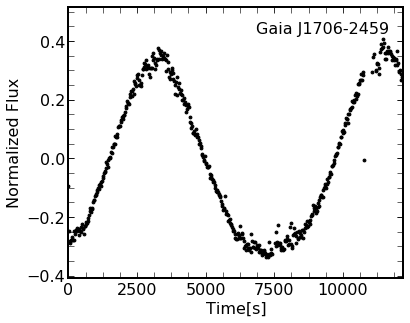

In [3]:
fig, ax = plt.subplots(figsize=(6,5)) #plot the data
ax.scatter(time-time[0],flux,color='black',s=8,label='Gaia J1706-2459')
ax.set_xlim([np.min(time-time[0]),np.max(time-time[0])])
y_span=np.max(flux)-np.min(flux)
ax.set_ylim([np.min(flux)-0.1*y_span, np.max(flux)+0.15*y_span]) #a lot of extra making things pretty stuff
ax.set_xlabel('Time[s]',fontsize=16)
ax.set_ylabel('Normalized Flux',fontsize=16)
ax.minorticks_on()
ax.xaxis.set_ticks_position('both'); ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='x',which='both',direction='in',length=6,labelsize=16); ax.tick_params(axis='y',which='both',direction='in',length=6,labelsize=16)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.legend(loc='upper right',frameon=False,markerscale=0,fontsize=16)

As you can see again, the data very well models a sine wave; however, a better fit would come from the summation of the fundamental and first harmonic sine waves.  You can tell this is the case due to the higher peaks and the thinner structure of the wave.  These functions are very easy to study with the sliders since they are simple wave equations. For one sine wave the general form would be:
$$ A\sin(\frac{2\pi}{P}t+\phi)+\Lambda $$
where A is your semi-amplitude, P is the period of binary, $\phi$ is the phase offset of the wave, and $\Lambda$ is some vertical offset. For the addition of two waves, the formula is:
$$ A\sin(\frac{2\pi}{P}t+\phi_{1})+B\sin(\frac{4\pi}{P}t+\phi_{2})+\Lambda $$
where A is the semi-amplitude of the fundamental wave, B is the semi-amplitude of the first harmonic, the $\phi$'s are phase offsets for their respective wave, and $\Lambda$ is some vertical offset.

The period for this binary is about 2.3 hours, so that will be a given for every calculation.

Now that we have the equations and the data, we can build sliders that correspond to the different parameters and update the fit for each wave in real time.  This is done by calculating the wave's value at every time point in the data set.  We can also return the values of the sliders using global variables that we can plug into the curve_fit function later.  Let's start with the case of one sine wave.  

In [4]:
#variables that are used to return the slider information for fitting
a_1 = 0 ; a_2 = 0; b_2 = 0; phi_1 = 0; phi_2a = 0; phi_2b = 0; dc1 = 0; dc2 = 0

# Creating sliders and finding parameters

In the cell below we make a function to allow the sliders to plot what the fit would look like for the case of one sine wave.  We then return the values of the sliders so that when we are satisfied with the fits, we can use the values without having to look back at the slider or risk bumping the slider again.

In [5]:
def sliders1(a,phi,dc): #passes through the unknown parameters
    p = 2.3*3600 #converting the period to seconds
    
    fig, ax = plt.subplots(figsize=(5,4))
    ax.scatter(time-time[0],flux,color='black',s=8,label='Gaia J1706-2459') #plots the data
    ax.set_xlim([np.min(time-time[0]),np.max(time-time[0])])
    y_span=np.max(flux)-np.min(flux)
    ax.set_ylim([np.min(flux)-0.1*y_span, np.max(flux)+0.15*y_span])
    ax.set_xlabel('Time[s]',fontsize=12)
    ax.set_ylabel('Normalized Flux',fontsize=12)
    ax.minorticks_on()
    ax.xaxis.set_ticks_position('both'); ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='x',which='both',direction='in',length=6,labelsize=12); ax.tick_params(axis='y',which='both',direction='in',length=6,labelsize=12)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.legend(loc='upper right',frameon=False,markerscale=0,fontsize=12)
    
    yfit = a*np.sin(((2*np.pi)/p)*time+phi)+dc #calculates what the sine wave fit would like like with the given slider values
    
    plt.plot(time-time[0],yfit,color='orange') #plots the sine wave fit
    
    global a_1,phi_1,dc1 #returns the values that the sliders are at to variables we can use later
    a_1 = a
    phi_1 = phi
    dc1 = dc
    
    plt.show()
    

Now we can generate the sliders and play with them while seeing the fit in real time! I have done this one and found the best parameters to be a=0.34,$\phi$=3.5, and dc=0 by my eye. Feel free to play with them to see what the fit does by changing each parameter.

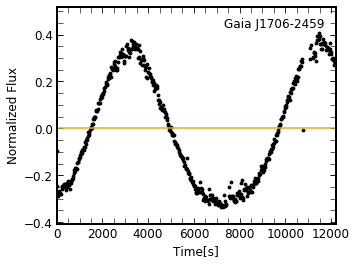

In [6]:
sin_1 = interactive(sliders1,a=(-1,1,0.01),phi=(0,2*np.pi),dc=(-0.5,0.5,0.01)) #sets up the sliders and plots the output of
sin_1  #                                                                        the function

In [96]:
print(a_1,phi_1,dc1) #prints out the values of the holder variables to show they are stored

0.34 3.5 0.0


As you can see by the ouput with my parameters, the fit doesn't quite match one sine wave, so let's move on to an example with two waves.  Once again we make a function to allow the sliders to generate a function in real time, and we return the values of the slider for fitting later.

In [97]:
def sliders2(a,b,phi1,phi2,dc): #passes through the unknown parameters
    p = 2.3*3600 #converting the period to seconds
    
    fig, ax = plt.subplots(figsize=(5,4))
    ax.scatter(time-time[0],flux,color='black',s=8,label='Gaia J1706-2459') #plots the data
    ax.set_xlim([np.min(time-time[0]),np.max(time-time[0])])
    y_span=np.max(flux)-np.min(flux)
    ax.set_ylim([np.min(flux)-0.1*y_span, np.max(flux)+0.15*y_span])
    ax.set_xlabel('Time[s]',fontsize=12)
    ax.set_ylabel('Normalized Flux',fontsize=12)
    ax.minorticks_on()
    ax.xaxis.set_ticks_position('both'); ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='x',which='both',direction='in',length=6,labelsize=12); ax.tick_params(axis='y',which='both',direction='in',length=6,labelsize=12)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.legend(loc='upper right',frameon=False,markerscale=0,fontsize=12)
    
    yfit = a*np.sin(((2*np.pi)/p)*time+phi1)+b*np.sin(((4*np.pi)/p)*time-np.pi/2+phi2)+dc #calculates what the sine wave fit would like like with the given slider values
    
    plt.plot(time-time[0],yfit,color=(0.5,1,0.8)) #plots the sine wave fit
    
    global a_2,phi_2a,b_2,phi_2b,dc2
    a_2 = a
    phi_2a = phi1
    phi_2b = phi2
    b_2 = b
    dc2 = dc
    
    plt.show()

Here we make another output so you can see how the fit is doing.  Play with the sliders until you think the fit is correct! (if it doesn't keep my values stored until you run the cell, no peeking!)

In [98]:
sin_2 = interactive(sliders2,a=(-1,1,0.01),b=(-1,1,0.01),phi1=(0,2*np.pi),phi2=(0,2*np.pi),dc=(-0.5,0.5,0.01)) #sets up the sliders
sin_2  # plots the output of the function

In [99]:
print(a_2,b_2,phi_2a,phi_2b,dc2) #prints out the values of the holder variables to show they are stored

0.31 0.0 3.5 0.7 -0.05


When I used the sliders, the best fit was a=0.32,b=0.05,$\phi_{1}$=3.5,$\phi_{2}$=0.7, and dc=-0.03.  As you can see, this fits a lot better than the one sine wave model, and the model would fit better with three even, definitionally.  Now we have played with many parameters and got ones that work well, so let's see how we did by using curve_fit.  

# Curve fitting with our parameters

Here we define the functions for each wave to curve fit.  Curve fitting will always be the final step in this process because it is more accurate and gives error on your, but we took care of a potential problem of coming up with the initial parameters before hand with the sliders!

In [100]:
def single_sin(t,a,phi,dc):   #defines two functions for curve fitting
    p = 2.3*3600
    return a*np.sin(((2*np.pi)/p)*t+phi)+dc
def two_sin(t,a,b,phi1,phi2,dc):
    p = 2.3*3600
    return a*np.sin(((2*np.pi)/p)*t+phi1)+b*np.sin(((4*np.pi)/p)*t-np.pi/2+phi2)+dc

Now that we have the functions, we can pass them through curve fit using our slider values as initial conditions!

In [101]:
params1,cov1 = curve_fit(single_sin,time,flux,p0=(a_1,phi_1,dc1))  #curve fits the two functions
params2,cov2 = curve_fit(two_sin,time,flux,p0=(a_2,b_2,phi_2a,phi_2b,dc2))
print(params1,'\n')
print(params2)

[ 0.33738555  3.49740636 -0.03624032] 

[ 0.32752602  0.05278722  3.52985162  0.73942799 -0.03534011]


Looking at the outputs from curve fit, we did a good job guessing all of the different parameters! Many of theme we were only a few decimal places off since curve_fit was more accurate.  Now all that is left to do is plotting the outputs from curve fit!

<IPython.core.display.Javascript object>


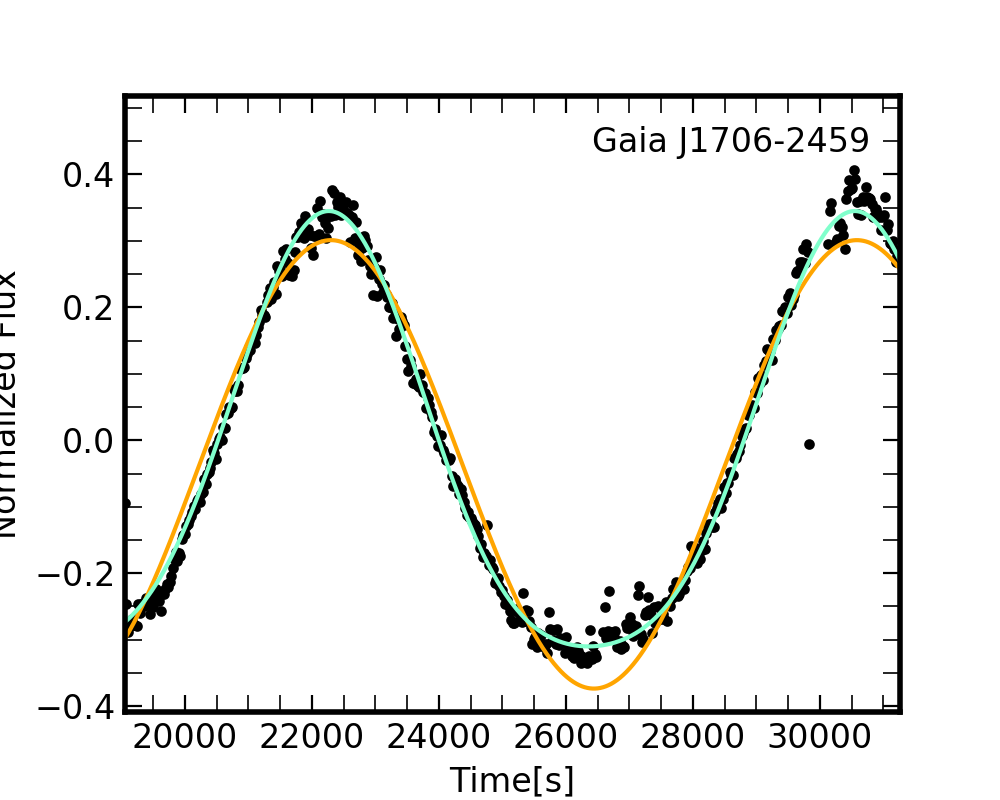

In [102]:
xfit = np.linspace(0,np.max(time),10000)  #creates an output for the curve fit
yfit1 = single_sin(xfit,*params1) 
yfit2 = two_sin(xfit,*params2)

fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(time,flux,color='black',s=8,label='Gaia J1706-2459')
ax.set_xlim([np.min(time),np.max(time)])
y_span=np.max(flux)-np.min(flux)
ax.set_ylim([np.min(flux)-0.1*y_span, np.max(flux)+0.15*y_span])
ax.set_xlabel('Time[s]',fontsize=12)
ax.set_ylabel('Normalized Flux',fontsize=12)
ax.minorticks_on()
ax.xaxis.set_ticks_position('both'); ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='x',which='both',direction='in',length=6,labelsize=12); ax.tick_params(axis='y',which='both',direction='in',length=6,labelsize=12)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.legend(loc='upper right',frameon=False,markerscale=0,fontsize=12)  #plots the data and the fits

plt.plot(xfit,yfit1,color='orange',label='Fundamental')
plt.plot(xfit,yfit2,color=(0.5,1,0.8),label='Sum of two')

As you can see, the two sine wave model fits the best, and it closely resembles the model we came up with on the sliders.

# Summary
This method of using sliders to help tune guesses for models was accomplished by simply adding the extra interactive function from ipywidgets.  I personally find this method exciting because it will likely make my life a lot easier when I have to plot things for O-C diagrams (where I sometimes have upwards of 15 variables that all do different things)!  I hope you enjoyed learning about the sliders and how this method could be useful!

## Bibliography
[*Knigge, C., Baraffe, I., & Patterson, J. 2011, ApJS, 194, 28*](https://arxiv.org/pdf/1108.4716.pdf)

[*Rappaport, S et al. 2017, MNRAS, 471, 948–961*](https://arxiv.org/pdf/1705.05863.pdf)